In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
!pip install d2l==0.14.3
!pip install -U mxnet-cu101mkl==1.6.0.post0  # updating mxnet to at least v1.6

     |████████████████████████████████| 53 kB 334 kB/s 
     |████████████████████████████████| 712.3 MB 254 bytes/s 


In [3]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import nn
npx.set_np()

In [4]:
# Read the train and the test data
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
# see the shapes of the data
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [6]:
# lets look at the first 5 rows of the train_data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# Id is unnecessary for our prediction purposes so we won't include that in out all features
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:,1:]))

In [8]:
# Data preprocessing
# First we take numeric features and apply standardization
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

In [9]:
# after standardizing there might be some numerical values which are still null
# so we replace them with 0 which won't affect our mean and stddev
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [10]:
# next we want to encode the categorical variables using one-hot encoding
# we consider null as a category
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
# now finally split the whole dataset into train_features and test_features
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.SalePrice.values.reshape(-1, 1), dtype=np.float32)

In [12]:
# we will use a basic linear model
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [13]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


In [15]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate([X_train, X_part], 0)
            y_train = np.concatenate([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

    

In [16]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

        

fold 1, train log rmse 0.169505, valid log rmse 0.157024
fold 2, train log rmse 0.162448, valid log rmse 0.189270
fold 3, train log rmse 0.163552, valid log rmse 0.167903
fold 4, train log rmse 0.168015, valid log rmse 0.154775
fold 5, train log rmse 0.162716, valid log rmse 0.182867
5-fold validation: avg train log rmse: 0.165247, avg valid log rmse: 0.170368


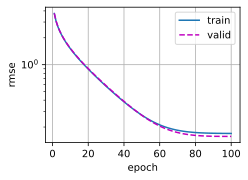

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [18]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = d2l.numpy(net(test_features))
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162471


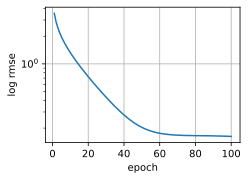

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)